In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import os
import pandas as pd
import numpy as np

In [46]:
def load_dataset_as_dataframe(subdir):
    # Define the path to the dataset
    data_dir = f'/content/drive/MyDrive/Health-AI_model/pneumonia/chest_xray/{subdir}'
    print(f'Load dataset from `{subdir}` subdirectory')

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Get the list of class directories
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    # Map class names to labels
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        # label = class_to_idx[class_name]
        label = class_name
        # Get all image files in the class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(len(classes)):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

In [47]:
classes = ['NORMAL', 'PNEUMONIA']
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')
val_df = load_dataset_as_dataframe('val')

Load dataset from `train` subdirectory
Classes: ['NORMAL', 'PNEUMONIA']
{0: 0, 1: 0}

Load dataset from `test` subdirectory
Classes: ['NORMAL', 'PNEUMONIA']
{0: 0, 1: 0}

Load dataset from `val` subdirectory
Classes: ['NORMAL', 'PNEUMONIA']
{0: 0, 1: 0}



In [48]:
val_df.head()

,image_path,label
0,/content/drive/MyDrive/Health-AI_model/pneumon...,NORMAL
1,/content/drive/MyDrive/Health-AI_model/pneumon...,NORMAL
2,/content/drive/MyDrive/Health-AI_model/pneumon...,NORMAL
3,/content/drive/MyDrive/Health-AI_model/pneumon...,NORMAL
4,/content/drive/MyDrive/Health-AI_model/pneumon...,NORMAL


In [49]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(5216, 2)
(624, 2)
(16, 2)


In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="image_path",y_col="label",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=True            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="image_path", y_col="label",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="image_path", y_col="label",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )


Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


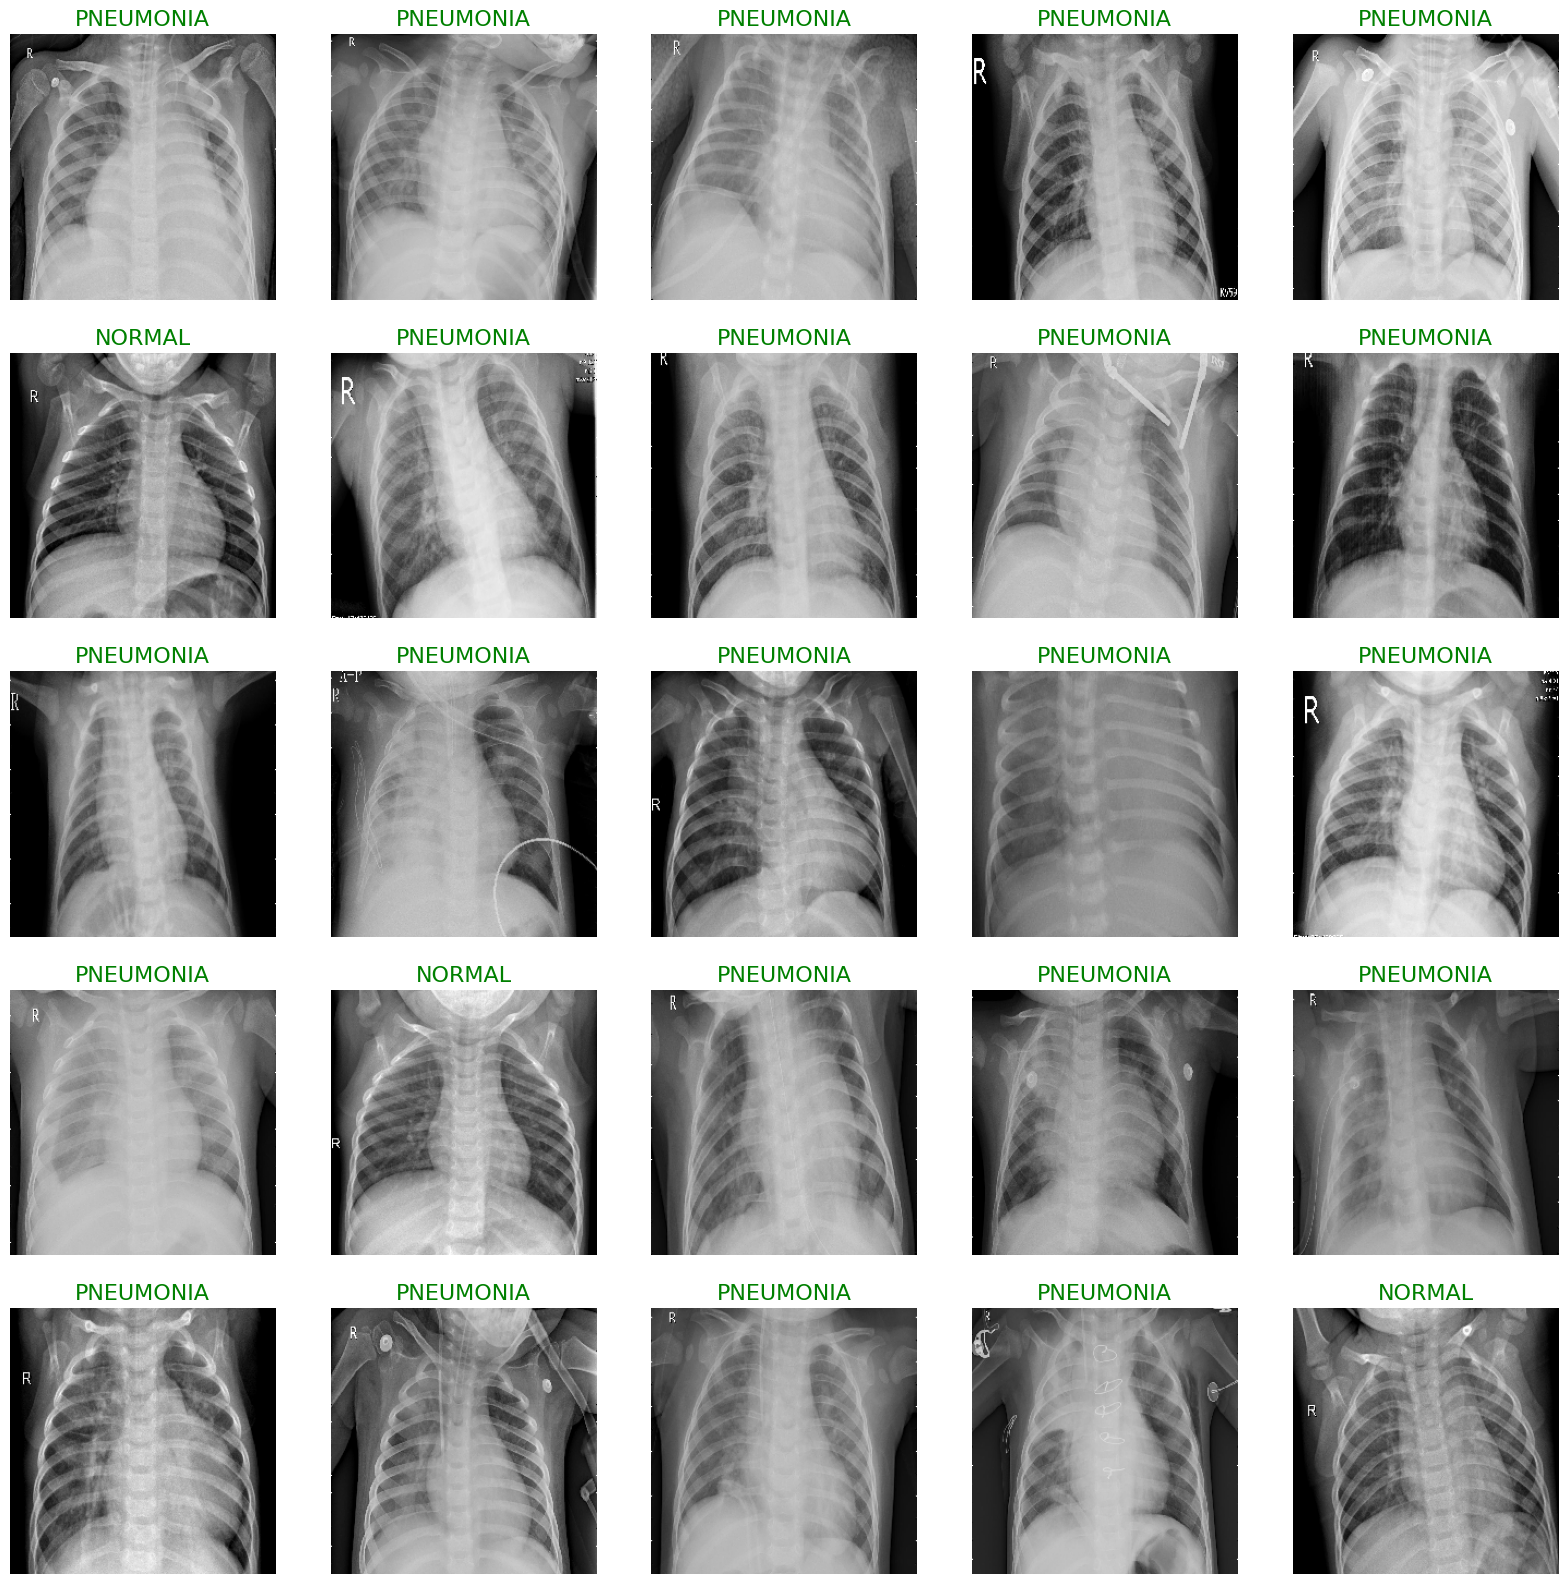

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

show_images(train)

In [52]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,609,474 (59.55 MB)

 Trainable params: 15,603,074 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [53]:
with tf.device('/device:GPU:0'):
  history = model.fit(train, epochs=30, validation_data=test, validation_freq=1)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 887s 5s/step - accuracy: 0.7838 - loss: 0.6499 - val_accuracy: 0.6250 - val_loss: 1.8830
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 477ms/step - accuracy: 0.9102 - loss: 0.2588 - val_accuracy: 0.6250 - val_loss: 4.0719
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 477ms/step - accuracy: 0.9394 - loss: 0.1779 - val_accuracy: 0.6250 - val_loss: 3.1651
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 469ms/step - accuracy: 0.9496 - loss: 0.1378 - val_accuracy: 0.7035 - val_loss: 1.1504
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 475ms/step - accuracy: 0.9577 - loss: 0.1240 - val_accuracy: 0.7436 - val_loss: 0.9590
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 472ms/step - accuracy: 0.9612 - loss: 0.1067 - val_accuracy: 0.7532 - val_loss: 0.9126
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 471ms/step - accuracy: 0.9703 - loss: 0.0795 - val_accuracy: 0.7596 - val_loss: 0.9549
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 464ms/step - accuracy: 0.9731 - loss: 0.0848 - val_a

In [54]:
model.evaluate(test, verbose=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.5841 - loss: 2.4363


[1.4496623277664185, 0.7660256624221802]

In [55]:
model.save('/content/drive/MyDrive/Health-AI_model/pneumonia/CNN_model-v2.h5')

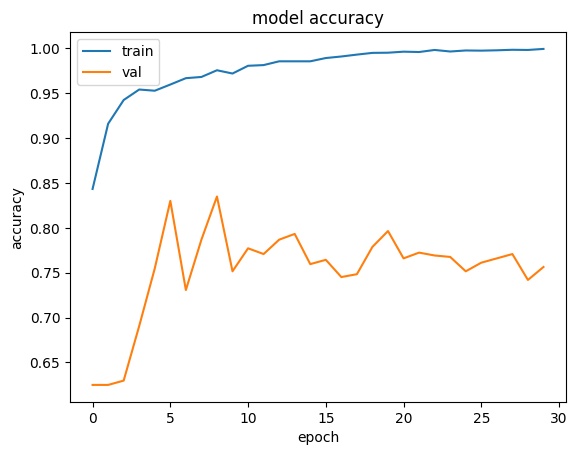

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

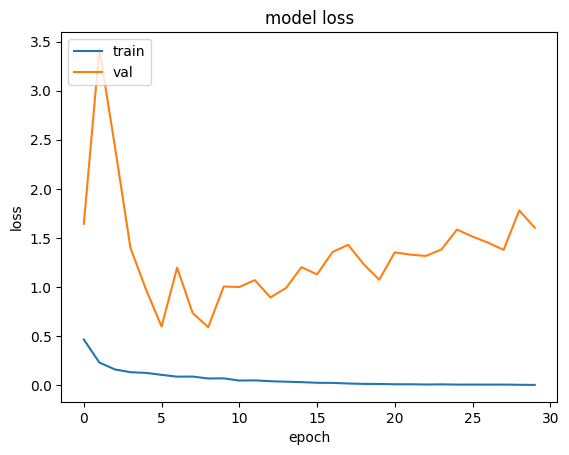

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [57]:
model = keras.models.load_model('/content/drive/MyDrive/Health-AI_model/pneumonia/CNN_model-v2.h5')
pred = model.predict(val)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

y_test = val_df.label # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      NORMAL       1.00      0.62      0.77         8
   PNEUMONIA       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16

Accuracy of the Model: 81.2%


### Prediction

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Health-AI_model/pneumonia/CNN_model-v2.h5')
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

# Define class labels
class_labels = ['NORMAL', 'PNEUMONIA']

def predict_image(img_path):
    """
    Predict the class of an input image using the trained model.

    Args:
        img_path (str): Path to the input image.

    Returns:
        dict: Predicted class with probability scores for each class.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to model's input size
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Preprocess as in training

    # Perform prediction
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]  # Get class with highest probability
    predicted_probs = {class_labels[i]: float(predictions[0][i]) for i in range(len(class_labels))}

    return {
        "Predicted Class": predicted_class,
        "Probability Scores": predicted_probs
    }

# Test the function
img_path = '/content/p2.jpeg'
result = predict_image(img_path)

print("Predicted Class:", result["Predicted Class"])
print("Probability Scores:", result["Probability Scores"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Predicted Class: PNEUMONIA
Probability Scores: {'NORMAL': 3.232933067920385e-06, 'PNEUMONIA': 0.9999967813491821}
